The k-modes algorithm uses a simple matching dissimilarity measure
to deal with categorical objects, replaces the means of clusters with modes, and uses a frequency-based method to
update modes in the clustering process to minimize the clustering cost function. With these extensions the k-modes
algorithm enables the clustering of categorical data in a fashion similar to k-means

In [1]:
'''Load Packages'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings
from sklearn.cluster import KMeans 
import random
from sklearn import metrics 
from scipy.spatial.distance import cdist
from kmodes.kmodes import KModes

In [2]:
## load data set
carmax_df = pd.read_csv('CaseDataRemodeled.csv')
new_df = pd.read_csv('newdata.csv')

In [3]:
carmax_df['job_assign'] = new_df['job_assign']
carmax_df['customer_income'] = new_df['new_income']
carmax_df['customer_age'] = new_df['new_ages']
carmax_df['purchase_price'] = new_df['purchase_price']

In [4]:
carmax_df.head()

,purchase_make,purchase_model,purchase_vehicle_year,purchase_price_LB,purchase_price_UB,trade_in,vehicle_financing,customer_age,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,post_purchase_satisfaction,vehicle_warranty_used,subsequent_purchases,AgeBin,purchase_class,made_in,job_assign,purchase_price
0,DODGE,CHARGER,2012,15001.0,20000.0,1,1,21 - 30,40001 - 60000,U,0,8.0,?,0,1,Twenties,sedan,UNITED STATES,"Life, Physical, and Social Science Technicians...",15001 - 20000
1,FORD,F150,2007,15001.0,20000.0,0,0,51 - 60,0 - 20000,F,1,19.0,?,0,0,Fifties,truck,UNITED STATES,"Entertainers and Performers, Sports and Relate...",15001 - 20000
2,BMW,328,2010,25001.0,30000.0,1,1,41 - 50,60001 - 80000,F,1,21.0,?,0,0,Forties,sedan,GERMANY,Farm Labor Contractors,25001 - 30000
3,LEXUS,GS 300,2003,10001.0,15000.0,0,1,21 - 30,20001 - 40000,M,0,8.0,?,0,0,Twenties,sedan,JAPAN,Painting Workers,10001 - 15000
4,CHEVROLET,CRUZE,2012,15001.0,20000.0,1,1,31 - 40,120001 - 140000,M,1,5.0,?,1,1,Thirties,sedan,UNITED STATES,Natural Sciences Managers,15001 - 20000


In [5]:
cluster_df = carmax_df.copy().drop(['customer_age','customer_previous_purchase','customer_distance_to_dealer',
                             'post_purchase_satisfaction','vehicle_warranty_used','purchase_price_LB',
                             'purchase_price_UB','purchase_class','job_assign','purchase_vehicle_year'], axis=1)

In [6]:
cluster_df['purchase_class'] = carmax_df['purchase_class']
cluster_df

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,subsequent_purchases,AgeBin,made_in,purchase_price,purchase_class
0,DODGE,CHARGER,1,1,40001 - 60000,U,1,Twenties,UNITED STATES,15001 - 20000,sedan
1,FORD,F150,0,0,0 - 20000,F,0,Fifties,UNITED STATES,15001 - 20000,truck
2,BMW,328,1,1,60001 - 80000,F,0,Forties,GERMANY,25001 - 30000,sedan
3,LEXUS,GS 300,0,1,20001 - 40000,M,0,Twenties,JAPAN,10001 - 15000,sedan
4,CHEVROLET,CRUZE,1,1,120001 - 140000,M,1,Thirties,UNITED STATES,15001 - 20000,sedan
...,...,...,...,...,...,...,...,...,...,...,...
355869,JEEP,LIBERTY,0,1,20001 - 40000,F,0,Twenties,UNITED STATES,15001 - 20000,wagon
355870,CHEVROLET,SONIC,1,0,20001 - 40000,U,0,Seventies,UNITED STATES,10001 - 15000,sedan
355871,KIA,SORENTO,1,1,20001 - 40000,F,1,Sixties,SOUTH KOREA,15001 - 20000,suv
355872,NISSAN,350Z,0,1,40001 - 60000,M,0,Twenties,JAPAN,10001 - 15000,coupe


In [7]:
sedan = cluster_df[cluster_df.purchase_class=='sedan'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
truck = cluster_df[cluster_df.purchase_class=='truck'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
suv = cluster_df[cluster_df.purchase_class=='suv'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
wagon = cluster_df[cluster_df.purchase_class=='wagon'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
van = cluster_df[cluster_df.purchase_class=='van'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
coupe = cluster_df[cluster_df.purchase_class=='coupe'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)
convertible = cluster_df[cluster_df.purchase_class=='convertible'].copy().reset_index(drop = True).drop('purchase_class', axis = 1)

vehicle_classes = [sedan,truck,suv,wagon,van,coupe,convertible]

In [8]:
# vehicle_classes_name = ['sedan','truck','suv','wagon','van','coupe','convertible']
# index = 0

# for group in vehicle_classes:
#     K = range(1,10) 
#     inertias = []
#     mapping2 = {} 
    
#     for k in K: 
#         #Building and fitting the model 
#         kmodesModel = KModes(n_clusters=k, init='Huang', n_init=5, verbose=0)
#         kmodesModel.fit(group.values)     
       
#         inertias.append(kmodesModel.cost_) 
  
#         mapping2[k] = kmodesModel.cost_ 
    
#     print(vehicle_classes_name[index])
#     index += 1
    
#     for key,val in mapping2.items(): 
#         print(str(key)+' : '+str(val)) 
    
#     plt.plot(K, inertias, 'bx-') 
#     plt.xlabel('Values of K') 
#     plt.ylabel('Inertia') 
#     plt.title('The Elbow Method using Inertia') 
#     plt.show()   

In [9]:
#k_values = [7,7,6,6,6,6,6]
ref = {}
vehicle_classes_name = ['sedan','truck','suv','wagon','van','coupe','convertible']
index = 0

for group in vehicle_classes:  
    k_modes = KModes(n_clusters=7, init='Huang', n_init=5, verbose=0,random_state = 2013)
    ref[vehicle_classes_name[index]] = k_modes.fit(group.values)    
    labels = k_modes.labels_
    group["cluster_label"] = labels
    index += 1


In [10]:
# k_modes = KModes(n_clusters=7, init='Huang', n_init=5, verbose=0,random_state = 2013)
    
# #k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=50,algorithm = "elkan",random_state = 2013)
    
# k_modes.fit(suv.values)
# labels = k_modes.labels_
# suv["cluster_label"] = labels

In [11]:
# test = suv.groupby(['cluster_label','purchase_model']).count().reset_index()
# test = test.sort_values(by=['cluster_label','purchase_price'],ascending=[True,False])
# test = test.groupby('cluster_label').head(10)[['cluster_label','purchase_model','purchase_price']]
# test.pivot(index = 'purchase_model',columns='cluster_label',values='purchase_price').fillna(0).style.highlight_max(color = 'green').format(int)

In [12]:
test = suv.groupby(['cluster_label','made_in']).count().reset_index()
test = test.sort_values(by=['cluster_label','purchase_make'],ascending=[True,False])
test.pivot(index = 'made_in',columns='cluster_label',values='purchase_make').fillna(0).style.highlight_max(color = 'green').format(int)

cluster_label,0,1,2,3,4,5,6
made_in,,,,,,,
GERMANY,669,783,3559,117,63,403,124
JAPAN,3569,2611,1945,9282,1501,10047,7126
SOUTH KOREA,1483,1049,892,345,689,554,398
SWEDEN,122,109,113,67,67,79,61
UNITED KINGDOM,186,191,160,39,167,176,162
UNITED STATES,12208,15386,1789,393,9535,1663,1488


In [13]:
sedan.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,subsequent_purchases,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,,
0,FORD,FUSION,1,0,20001 - 40000,M,0,Thirties,UNITED STATES,15001 - 20000
1,NISSAN,ALTIMA,1,1,20001 - 40000,F,0,Twenties,JAPAN,10001 - 15000
2,CHEVROLET,MALIBU,0,1,20001 - 40000,M,0,Twenties,UNITED STATES,15001 - 20000
3,TOYOTA,CAMRY,0,1,60001 - 80000,F,0,Thirties,JAPAN,15001 - 20000
4,NISSAN,ALTIMA,0,1,40001 - 60000,M,0,Thirties,JAPAN,15001 - 20000
5,TOYOTA,COROLLA,0,1,20001 - 40000,M,0,Thirties,JAPAN,10001 - 15000
6,BMW,328,0,1,0 - 20000,M,0,Forties,GERMANY,10001 - 15000


In [14]:
truck.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,subsequent_purchases,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,,
0,CHEVROLET,SILVERADO 1500,0,0,40001 - 60000,M,0,Forties,UNITED STATES,10001 - 15000
1,FORD,F150,0,1,60001 - 80000,M,0,Fifties,UNITED STATES,15001 - 20000
2,CHEVROLET,SILVERADO 1500,1,1,60001 - 80000,M,0,Twenties,UNITED STATES,15001 - 20000
3,TOYOTA,TACOMA,1,1,40001 - 60000,M,0,Forties,JAPAN,20001 - 25000
4,DODGE,RAM 1500,1,1,20001 - 40000,M,0,Twenties,UNITED STATES,20001 - 25000
5,GMC,SIERRA 1500,1,1,40001 - 60000,M,0,Fifties,UNITED STATES,25001 - 30000
6,FORD,F150,1,1,20001 - 40000,M,0,Forties,UNITED STATES,10001 - 15000


In [15]:
suv.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,subsequent_purchases,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,,
0,JEEP,PATRIOT,0,1,40001 - 60000,F,0,Twenties,UNITED STATES,15001 - 20000
1,FORD,ESCAPE,0,1,20001 - 40000,M,0,Fifties,UNITED STATES,15001 - 20000
2,MERCEDES-BENZ,ML350,1,1,20001 - 40000,F,0,Thirties,GERMANY,20001 - 25000
3,HONDA,CR-V,0,1,60001 - 80000,F,0,Fifties,JAPAN,20001 - 25000
4,CHEVROLET,EQUINOX,1,1,40001 - 60000,F,0,Forties,UNITED STATES,10001 - 15000
5,TOYOTA,RAV4,1,1,40001 - 60000,M,1,Thirties,JAPAN,15001 - 20000
6,NISSAN,ROGUE,1,1,60001 - 80000,M,0,Thirties,JAPAN,20001 - 25000


In [16]:
wagon.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,subsequent_purchases,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,,
0,TOYOTA,PRIUS,0,1,40001 - 60000,F,0,Thirties,JAPAN,15001 - 20000
1,DODGE,CALIBER,1,1,20001 - 40000,F,0,Twenties,UNITED STATES,10001 - 15000
2,KIA,SOUL,1,1,40001 - 60000,M,1,Twenties,UNITED STATES,10001 - 15000
3,MINI,COOPER,1,1,40001 - 60000,M,0,Forties,UNITED KINGDOM,15001 - 20000
4,TOYOTA,YARIS,0,1,20001 - 40000,F,1,Twenties,JAPAN,10001 - 15000
5,KIA,SOUL,0,1,20001 - 40000,F,0,Forties,SOUTH KOREA,10001 - 15000
6,JEEP,LIBERTY,0,1,40001 - 60000,M,0,Thirties,UNITED STATES,10001 - 15000


In [17]:
van.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,subsequent_purchases,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,,
0,CHRYSLER,TOWN AND COUNTRY,0,0,20001 - 40000,F,0,Thirties,UNITED STATES,15001 - 20000
1,DODGE,GRAND CARAVAN,0,1,40001 - 60000,M,0,Forties,UNITED STATES,15001 - 20000
2,HONDA,ODYSSEY,1,1,40001 - 60000,M,1,Thirties,JAPAN,15001 - 20000
3,TOYOTA,SIENNA,1,1,60001 - 80000,F,0,Thirties,JAPAN,10001 - 15000
4,HONDA,ODYSSEY,0,1,60001 - 80000,M,0,Forties,JAPAN,20001 - 25000
5,TOYOTA,SIENNA,0,0,20001 - 40000,M,0,Forties,JAPAN,15001 - 20000
6,CHRYSLER,TOWN AND COUNTRY,1,1,40001 - 60000,M,0,Thirties,UNITED STATES,20001 - 25000


In [18]:
coupe.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,subsequent_purchases,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,,
0,MERCEDES-BENZ,C300,0,1,40001 - 60000,M,0,Forties,GERMANY,20001 - 25000
1,HONDA,ACCORD,1,1,60001 - 80000,M,0,Forties,JAPAN,15001 - 20000
2,HONDA,ACCORD,0,1,20001 - 40000,M,0,Twenties,JAPAN,15001 - 20000
3,HONDA,CIVIC,0,1,40001 - 60000,F,1,Twenties,JAPAN,10001 - 15000
4,DODGE,CHALLENGER,1,1,20001 - 40000,M,0,Twenties,UNITED STATES,20001 - 25000
5,HONDA,CIVIC,1,1,20001 - 40000,F,0,Thirties,JAPAN,15001 - 20000
6,HONDA,ACCORD,0,1,40001 - 60000,M,0,Thirties,JAPAN,15001 - 20000


In [19]:
convertible.groupby('cluster_label').agg(lambda x: pd.Series.mode(x)[0])

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,subsequent_purchases,AgeBin,made_in,purchase_price
cluster_label,,,,,,,,,,
0,CHEVROLET,CAMARO,1,1,20001 - 40000,F,1,Forties,UNITED STATES,20001 - 25000
1,MERCEDES-BENZ,E350,1,1,80001 - 100000,M,0,Forties,GERMANY,30001 - 35000
2,FORD,MUSTANG,0,1,40001 - 60000,M,0,Twenties,UNITED STATES,15001 - 20000
3,CHEVROLET,CAMARO,1,1,40001 - 60000,M,0,Twenties,UNITED STATES,25001 - 30000
4,JEEP,WRANGLER,0,1,40001 - 60000,M,0,Forties,UNITED STATES,20001 - 25000
5,VOLKSWAGEN,BEETLE,1,1,60001 - 80000,F,0,Fifties,GERMANY,15001 - 20000
6,CHEVROLET,CORVETTE,0,1,20001 - 40000,M,1,Fifties,UNITED STATES,25001 - 30000


In [20]:
k_modes.predict([['','','0','0','40001 - 60000','M','0','Forties','','25001 - 30000']])

array([3], dtype=uint16)

In [21]:
truck[truck.cluster_label == 1]

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,subsequent_purchases,AgeBin,made_in,purchase_price,cluster_label
0,FORD,F150,0,0,0 - 20000,F,0,Fifties,UNITED STATES,15001 - 20000,1
2,FORD,F150,0,1,40001 - 60000,U,0,Twenties,UNITED STATES,15001 - 20000,1
9,DODGE,RAM 1500,0,1,200001+,M,1,Fifties,UNITED STATES,15001 - 20000,1
11,FORD,F250,1,1,200001+,M,0,Fifties,UNITED STATES,30001 - 35000,1
12,TOYOTA,TACOMA,0,1,180001 - 200000,M,0,Fifties,JAPAN,15001 - 20000,1
...,...,...,...,...,...,...,...,...,...,...,...
28732,DODGE,RAM 2500,0,1,20001 - 40000,M,0,Sixties,UNITED STATES,15001 - 20000,1
28736,FORD,F150,0,0,0 - 20000,M,0,Thirties,UNITED STATES,45001 - 50000,1
28755,FORD,F150,1,0,0 - 20000,M,0,Sixties,UNITED STATES,15001 - 20000,1
28756,FORD,F150,0,1,60001 - 80000,M,0,Thirties,UNITED STATES,10001 - 15000,1


In [22]:
cluster_df.groupby('purchase_model').count().sort_values(by = 'purchase_make', ascending = False).rename(columns = {'purchase_make':'count'})[['count']].to_csv("counts.csv")

In [23]:
suv[suv.cluster_label == 2]

,purchase_make,purchase_model,trade_in,vehicle_financing,customer_income,customer_gender,subsequent_purchases,AgeBin,made_in,purchase_price,cluster_label
3,MERCEDES-BENZ,GLK350,0,0,60001 - 80000,F,1,Sixties,GERMANY,30001 - 35000,2
35,CADILLAC,SRX,1,0,20001 - 40000,F,0,Thirties,UNITED STATES,25001 - 30000,2
38,BMW,X3,1,1,160001 - 180000,F,1,Thirties,GERMANY,35001 - 40000,2
59,MERCEDES-BENZ,ML350,0,0,0 - 20000,U,0,Thirties,GERMANY,30001 - 35000,2
81,HONDA,CR-V,1,1,20001 - 40000,F,0,Thirties,JAPAN,15001 - 20000,2
...,...,...,...,...,...,...,...,...,...,...,...
91300,DODGE,JOURNEY,1,1,20001 - 40000,F,0,Twenties,UNITED STATES,20001 - 25000,2
91326,LINCOLN,MKX,1,1,20001 - 40000,F,0,Sixties,UNITED STATES,20001 - 25000,2
91330,CHEVROLET,TRAVERSE,1,1,60001 - 80000,F,0,Thirties,UNITED STATES,20001 - 25000,2
91348,TOYOTA,VENZA,1,1,20001 - 40000,F,0,Fifties,JAPAN,25001 - 30000,2


In [24]:
ref['suv'].cluster_centroids_

array([['JEEP', 'PATRIOT', '0', '1', '40001 - 60000', 'F', '0',
        'Twenties', 'UNITED STATES', '15001 - 20000'],
       ['FORD', 'ESCAPE', '0', '1', '20001 - 40000', 'M', '0', 'Fifties',
        'UNITED STATES', '15001 - 20000'],
       ['MERCEDES-BENZ', 'ML350', '1', '1', '20001 - 40000', 'F', '0',
        'Thirties', 'GERMANY', '20001 - 25000'],
       ['HONDA', 'CR-V', '0', '1', '60001 - 80000', 'F', '0', 'Fifties',
        'JAPAN', '20001 - 25000'],
       ['CHEVROLET', 'EQUINOX', '1', '1', '40001 - 60000', 'F', '0',
        'Forties', 'UNITED STATES', '10001 - 15000'],
       ['TOYOTA', 'RAV4', '1', '1', '40001 - 60000', 'M', '1',
        'Thirties', 'JAPAN', '15001 - 20000'],
       ['NISSAN', 'ROGUE', '1', '1', '60001 - 80000', 'M', '0',
        'Thirties', 'JAPAN', '20001 - 25000']], dtype='<U13')

In [25]:
coupe.purchase_price.unique()

array(['15001 - 20000', '10001 - 15000', '20001 - 25000', '25001 - 30000',
       '5001 - 10000', '50001 - 55000', '35001 - 40000', '30001 - 35000',
       '55001 - 60000', '45001 - 50000', '40001 - 45000', '75001 - 80000',
       '65001 - 70000', '?', '60001 - 65000', '85001 - 90000',
       '70001 - 75000', '80001 - 85000'], dtype=object)

In [26]:
#cluster_df.groupby('purchase_model').count().sort_values(by = 'purchase_make', ascending = False).rename(columns = {'purchase_make':'count'})[['count']].to_csv("counts.csv")

In [27]:
def top10cluster(cluster_name,
                 class_name,
                 p_make, 
                 p_model, 
                 t_in, 
                 vehicleFinance,
                 cust_income,
                 gender,
                 sub_purch,
                 Age,
                 madeIn, 
                 purch_price):
    cluster_number = ref[class_name].predict([[p_make, p_model, t_in, vehicleFinance,cust_income,gender,sub_purch,
                                               Age,madeIn, purch_price]])[0]
    
    return cluster_name[cluster_name.cluster_label == cluster_number].groupby(['purchase_make',
                                                                               'purchase_model']).count().sort_values(by = 'trade_in',
                                                                                                                      ascending = False).reset_index()[['purchase_make',
                                                                                                                      'purchase_model']].head(10)

In [28]:
top10cluster(cluster_name = truck,
             class_name = 'truck',
             p_make = 'TOYOTA',
             p_model = '',
             t_in = '0',
             vehicleFinance ='1',
             cust_income = '60001 - 80000',
             gender = 'M',
             sub_purch = '0',
             Age = 'Twenties',
             madeIn = 'UNITED STATES',
             purch_price ='30001 - 35000')        

,purchase_make,purchase_model
0,CHEVROLET,SILVERADO 1500
1,CHEVROLET,AVALANCHE 1500
2,CHEVROLET,COLORADO
3,CHEVROLET,SILVERADO 2500
4,NISSAN,FRONTIER
5,NISSAN,TITAN
6,DODGE,RAM 1500
7,TOYOTA,TUNDRA
8,HONDA,RIDGELINE
9,DODGE,DAKOTA


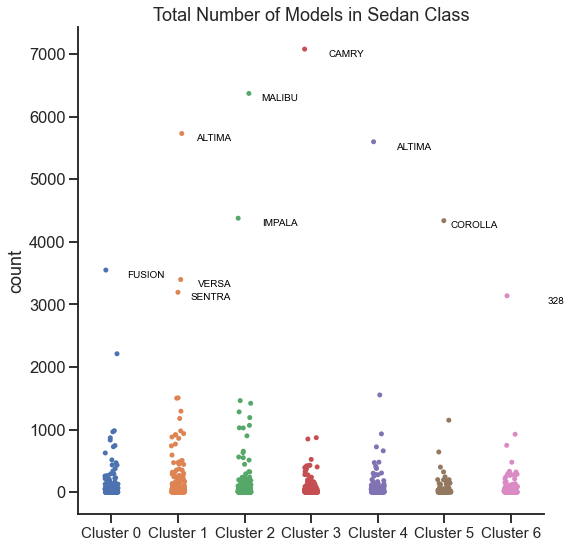

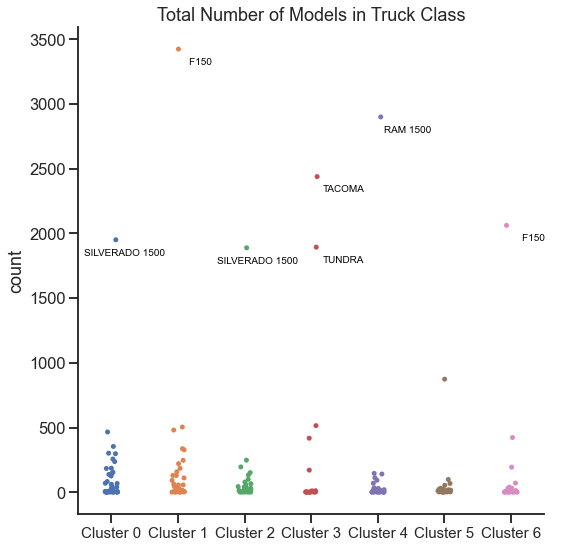

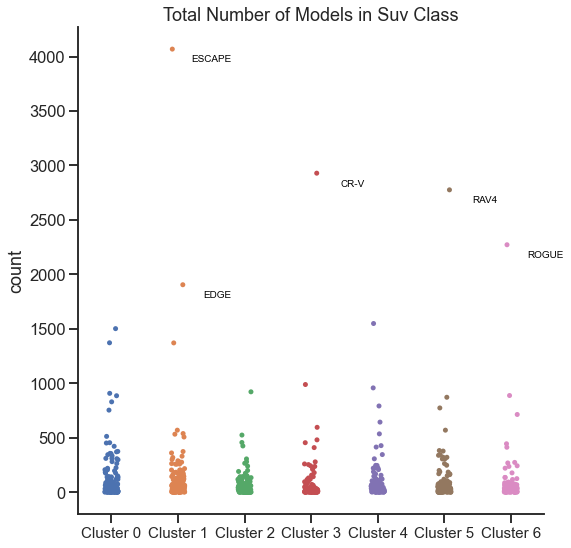

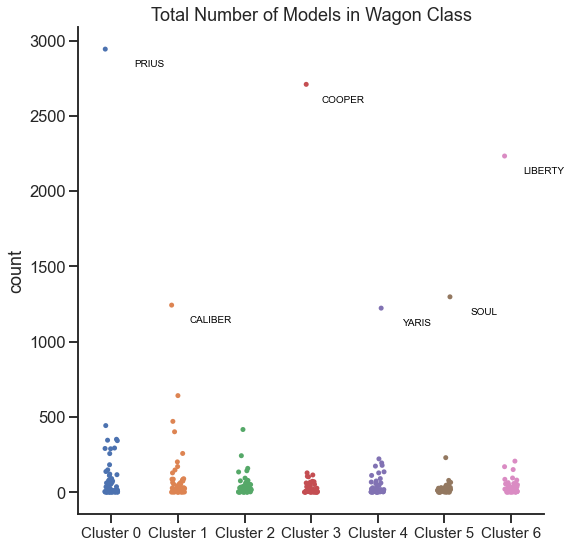

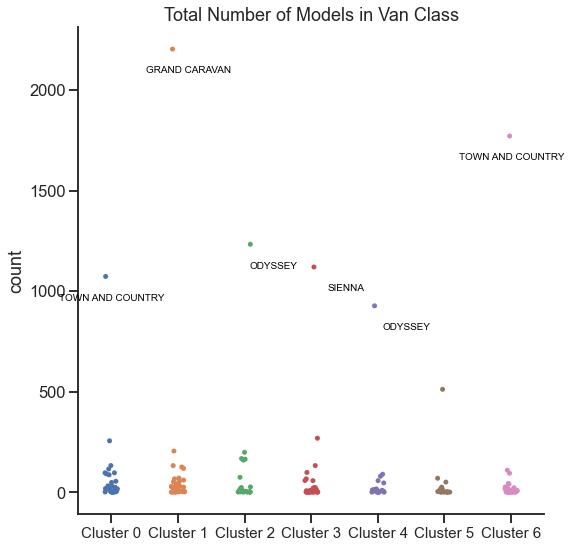

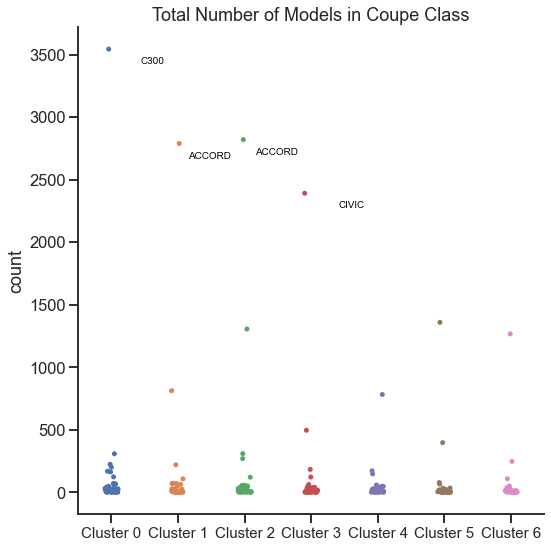

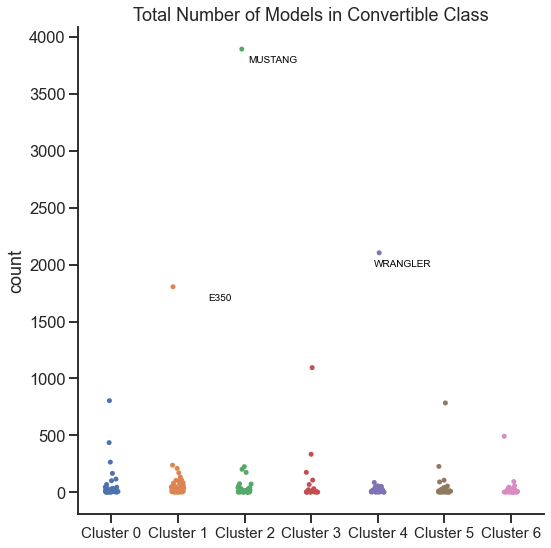

In [298]:
#sns.set_theme(style = "darkgrid")
#sns.set(rc={'axes.facecolor':'white'})

for index, car in enumerate(vehicle_classes):
    data = car.groupby(['purchase_make', 'purchase_model',
                        'cluster_label']).count().sort_values(by = 'cluster_label',ascending = False).reset_index()
    sns.set_style("ticks")
    sns.set_context("talk")

    p1 = sns.catplot(x = "cluster_label", y ='trade_in',order = [0,1,2,3,4,5,6], data = data,height = 8)
    for x, y, s in zip(data['cluster_label'], data['trade_in'],data['purchase_model']):
        if y > max(data['trade_in'])//2.5:
            if s == 'F150':
                s = s + '       '
            plt.text(x = x + .8, # x-coordinate position of data label
            y = y-120, # y-coordinate position of data label, adjusted to be 150 below the data point
            s = s, # data label, formatted to ignore decimals
            color = 'black',
            fontsize = 10,
            horizontalalignment='right') # set colour of line)

    p1.set(title='Total Number of Models in {0} Class'.format(vehicle_classes_name[index].capitalize() ))
    p1.set_axis_labels("", "count").set_xticklabels(["Cluster 0", 'Cluster 1',"Cluster 2", 'Cluster 3',"Cluster 4", 'Cluster 5',
                                                    'Cluster 6'], fontsize = 15)
    

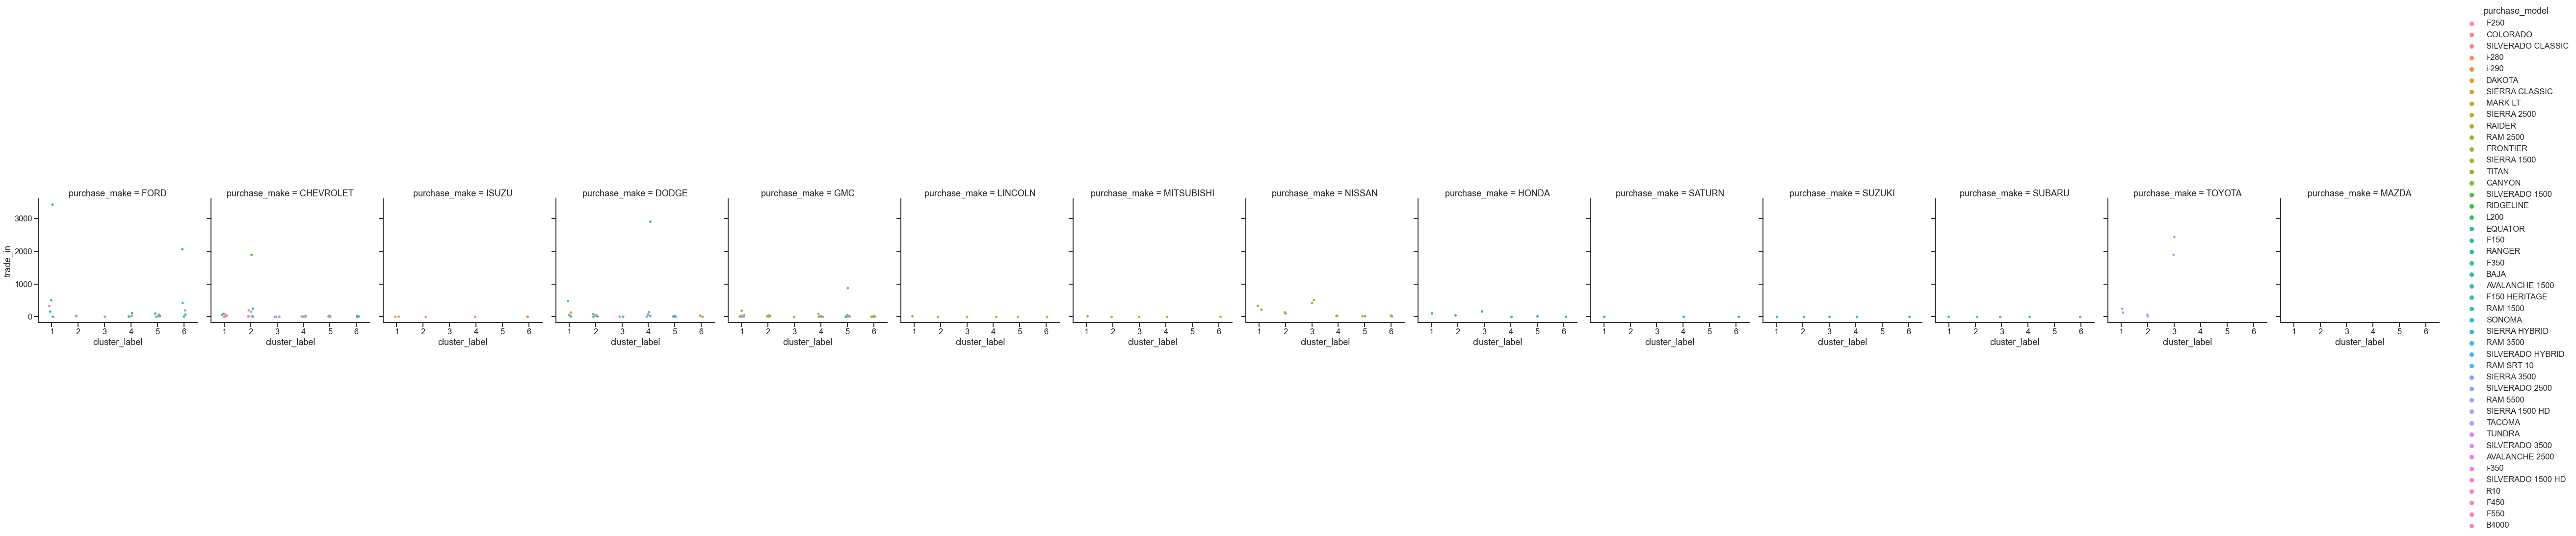

In [168]:
sns.catplot(x = "cluster_label", y ='trade_in',order = [1,2,3,4,5,6], data = tC, hue='purchase_model', col = "purchase_make")